In [ ]:
import re
import matplotlib.pyplot as plt
import string
import pandas as pd
import numpy as np
import csv

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.tokenize.treebank import TreebankWordDetokenizer

from gensim.utils import simple_preprocess

import tensorflow as tf
import keras

import os.path
from os import path

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load dataset & See stats

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dataset = pd.read_csv("/content/gdrive/My Drive/Datasets/datasetBalanced.csv") \
            .drop_duplicates(subset='text', keep="last")[['text','sentiment']] # Remove duplicates & keep columns to use
        
dataset.head(5)

,text,sentiment
0,Our palace team will put our hearts out for ou...,1
1,Chelsea v Palace kick-off time changed and TV ...,1
2,Academy redevelopment update: Exclusive footag...,1
3,@ChelseaFC I still have no entire clue why us ...,1
4,"Pizza fight suggestions wrong, #CPFC wonderkid...",0


In [ ]:
# Get the dataset lenght
len(dataset)

860452

In [ ]:
# Validate if there are different values from negative (0), neutral (1) and positive (2)
dataset['sentiment'].unique()

array([1, 0, 2])

In [ ]:
# How distributed is the dataset
dataset.groupby('sentiment').nunique()

,text
sentiment,
0,266239
1,309056
2,285157


# Data cleaning

Even when the dataset is a little bit biased, we'll keep it this way because the differences are not significant.

In [ ]:
# Fill null values.
dataset["text"].fillna("No content", inplace=True)

### The next steps about data cleaning will be:

* Remove URLs from the tweets
* Tokenize text
* Remove emails
* Remove new lines characters
* Remove distracting single quotes
* Remove all punctuation signs
* Lowercase all text
* Detokenize text
* Convert list of texts to Numpy array

In [ ]:
url_pattern = re.compile(r'https?://\S+|www\.\S+')
TAG_RE = re.compile(r'<[^>]+>')
ENCODING_RE = re.compile(r'\\x.[a-f0-9]')
EMOJI_RE = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)

def depure_data(data):
    #Removing URLs with a regular expression
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)

     #Remove @ sign
    data = re.sub("@[A-Za-z0-9]+","",data)

     #Remove http links
    data = re.sub(r"(?:@|http?://|https?://|www)\S+", "", data)

    #Remove Emojis
    data = EMOJI_RE.sub('', data)

    #Remove hashtag sign but keep the text
    data = re.sub("#[A-Za-z0-9]+","",data)

    #Forcing decode of UTF-8 characters
    #data = re.sub(r'[^\x00-\x7f]',r'', data)
    data = ENCODING_RE.sub('', data)

    # Remove html tags
    data = TAG_RE.sub('', data)

    return data

In [ ]:
list_words = stopwords.words('english')

remove_stopwords = lambda data: (" ").join([word for word in data.split() if not word in list_words]) # Remove unused words like will
processor = lambda sentence: simple_preprocess(str(sentence), deacc=True) # Lowecase, ponctuation & accents
detokenizer = lambda sequence: TreebankWordDetokenizer().detokenize(sequence) # Join sequence of tokens
perform_cleanup = lambda data: list([detokenizer(processor(remove_stopwords(depure_data(tweet)))) for tweet in data]) 

In [ ]:
tweets = dataset['text'].values.tolist()
tweets_len = len(tweets)

data = perform_cleanup(tweets)

print(data[:5])

['our palace team put hearts fans don billions fans solid family fans', 'chelsea palace kick off time changed tv information confirmed', 'academy redevelopment update exclusive footage shows new site progression', 'still entire clue us crystal palace wouldn go abraham he top shout tbh he look striker maybe next transfer', 'pizza fight suggestions wrong wonderkid says interview national media']


In [ ]:
data = np.array(data)

# Save cleaned data for performance purposes
pd.DataFrame(data).to_csv('/content/gdrive/My Drive/Datasets/cleaned_datasetBalanced.csv')

# Label encoding

As the dataset is categorical, we need to convert the sentiment labels from Neutral, Negative and Positive to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [ ]:
labels = tf.keras.utils.to_categorical(dataset['sentiment'], 3, dtype="float32")
print(labels)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


# Data sequencing and splitting

We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Conv1D, Dense, MaxPool1D, Flatten, Input, Dropout
from keras.layers import GlobalMaxPooling1D


from sklearn.model_selection import train_test_split

In [ ]:
max_words = 5000
max_len = 200

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ... 1145  434   27]
 [   0    0    0 ...  723 1782  436]
 [   0    0    0 ...  894    9 1170]
 ...
 [   0    0    0 ...  193  286  150]
 [   0    0    0 ...  169  991  218]
 [   0    0    0 ...  994 2182  177]]


In [ ]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, test_size=0.20, random_state=42)

print (len(X_train), len(X_test), len(y_train), len(y_test))

688361 172091 688361 172091


# Model building


## CNN layer model

In [ ]:
model = Sequential()

model.add(layers.Embedding(max_words, 20))

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1, save_weights_only=False)

batch_size=16 # 688361 samples / batch_size = Number of iterations per epoch
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), callbacks=[checkpoint1], batch_size=batch_size)

# Best model validation


In [ ]:
# Load the best model obtained during training
model = keras.models.load_model("best_model1.hdf5")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print('Model accuracy: ',test_acc)

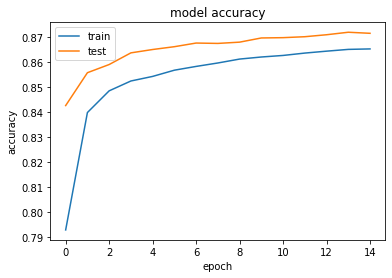

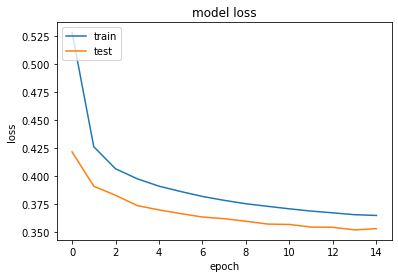

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Examples


In [ ]:
sentiment = ['Negative', 'Neutral','Positive']

In [ ]:
sequence = tokenizer.texts_to_sequences(['this experience has been the best, want my money back'])

test = pad_sequences(sequence, maxlen=max_len)

sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

In [ ]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])

test = pad_sequences(sequence, maxlen=max_len)

sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

In [ ]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are fantastic'])

test = pad_sequences(sequence, maxlen=max_len)

sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [ ]:
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])

test = pad_sequences(sequence, maxlen=max_len)

sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

###MATCH PREDICTIONS


In [ ]:
dataset = pd.read_csv("/content/gdrive/My Drive/Datasets/ManCity_VS_Spurs.csv")  \
           .drop_duplicates(subset='TWEET', keep="last")[['ID', 'TIMESTAMP', 'TWEET']] # Remove duplicates & keep columns to use

print(dataset.head(5))
print(len(dataset))

                    ID  ...                                              TWEET
0  1386369438908305417  ...  RT @ManCity: FULL TIME | WE'VE WON THE CARABAO...
1  1386369435376787468  ...  #ManCity win still it was nice of #Spurs to ma...
2  1386369434407907331  ...  Controlled. Majestic. Imposing. \n\nThat\xe2\x...
3  1386369434290380801  ...  Champions again \xf0\x9f\x92\x99\xe2\x9a\xbd\x...
4  1386369433367687168  ...  They do it again! Manchester City claim the Ca...

[5 rows x 3 columns]
1444


In [ ]:
#Split dataset into teams
team_ManCity_data = dataset[dataset['TWEET'].str.contains("#ManCity|#manchestercity")];
team_Spurs_data = dataset[dataset['TWEET'].str.contains("#Spurs|#Tottenham")];

print(team_ManCity_data)
print(team_Spurs_data)

                       ID  ...                                              TWEET
0     1386369438908305417  ...  RT @ManCity: FULL TIME | WE'VE WON THE CARABAO...
1     1386369435376787468  ...  #ManCity win still it was nice of #Spurs to ma...
3     1386369434290380801  ...  Champions again \xf0\x9f\x92\x99\xe2\x9a\xbd\x...
4     1386369433367687168  ...  They do it again! Manchester City claim the Ca...
9     1386369418750570500  ...  RT @cityreport_: \xf0\x9f\x8f\x86\xf0\x9f\x8f\...
...                   ...  ...                                                ...
4967  1386341780459859969  ...  'MAN CITY VS TOTTENHAM - WHAT DO YOU THINK THE...
4968  1386341764592771075  ...  KICK OFF | The quest for the Carabao starts no...
4969  1386341756913037316  ...  KICK-OFF | #ManCity 0-0 @SpursOfficial | COME....
4970  1386341746053894147  ...  #ManCity\xe2\x80\x99s starting lineup against ...
4972  1386341736247611400  ...  RT @ManCity: Wembley, \xf0\x9d\x98\x84\xf0\x9d...

[606 rows x 3 c

In [ ]:
team_ManCity = perform_cleanup(team_ManCity_data['TWEET'].values.tolist())
team_Spurs = perform_cleanup(team_Spurs_data['TWEET'].values.tolist())

print(team_ManCity[:5])

['rt full time weve won the carabao cup were mad it', 'win still nice make numbers', 'champions nand brilliant fans well top off', 'they again manchester city claim carabao cup fourth time row', 'rt']


In [ ]:
process = lambda dataset : list([sentiment[np.around(model.predict(pad_sequences(tokenizer.texts_to_sequences([tweet]), maxlen=max_len)), decimals=0).argmax(axis=1)[0]] for tweet in dataset])

sentiment_ManCity = process(team_ManCity)
sentiment_Spurs = process(team_Spurs)
print(sentiment_ManCity)
print(sentiment_Spurs)

['Negative', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Negative', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Positive', 'Negative', 'Neutral', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Negative', 'Negative', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Positive', 'Positive', 'Positive', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Neutral', 'N

In [ ]:
sentiment_ManCity = pd.DataFrame(sentiment_ManCity)
sentiment_Spurs = pd.DataFrame(sentiment_Spurs)

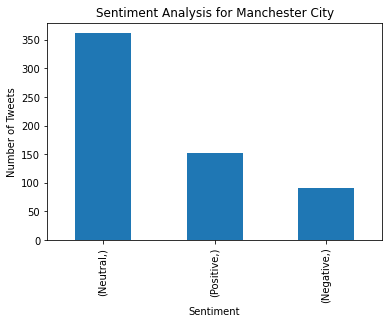

In [ ]:
sentiment_ManCity.value_counts().plot(kind='bar')

plt.title('Sentiment Analysis for Manchester City')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')

plt.show()

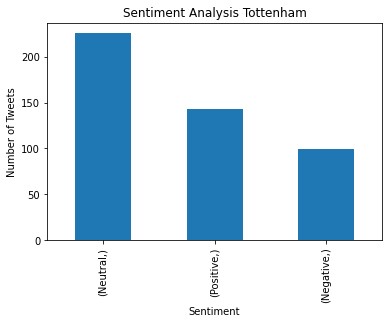

In [ ]:
sentiment_Spurs.value_counts().plot(kind='bar')

plt.title('Sentiment Analysis Tottenham')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

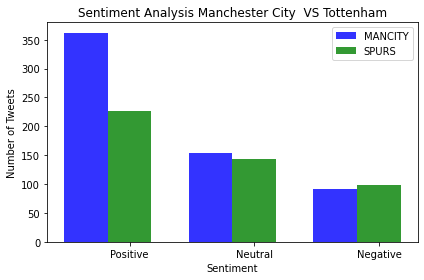

In [ ]:
manCityValueCounts = sentiment_ManCity.value_counts();
spursValueCounts = sentiment_Spurs.value_counts();

def pintaGraficos(values1, values2):
  # data to plot
  n_groups = len(spursValueCounts)

  means1 = (values1[0], values1[1], values1[2])
  means2 = (values2[0], values2[1], values2[2])

  # create plot
  fig, ax = plt.subplots()
  index = np.arange(n_groups)
  bar_width = 0.35
  opacity = 0.8

  rects1 = plt.bar(index, means1, bar_width,
  alpha=opacity,
  color='b',
  label='MANCITY')

  rects2 = plt.bar(index + bar_width,means2, bar_width,
  alpha=opacity,
  color='g',
  label='SPURS')

  plt.xlabel('Sentiment')
  plt.ylabel('Number of Tweets')
  plt.title('Sentiment Analysis Manchester City  VS Tottenham')
  plt.xticks(index + bar_width, ('Positive', 'Neutral', 'Negative'))
  plt.legend()

  plt.tight_layout()
  plt.show()

pintaGraficos(manCityValueCounts, spursValueCounts)

In [ ]:
manchester_city = team_ManCity_data.drop(columns="ID")
spurus = team_Spurs_data.drop(columns="ID")

manchester_city['Sentiment'] = sentiment_ManCity
spurus['Sentiment'] = sentiment_Spurs

print(len(manchester_city))
print(manchester_city.columns)
print(spurus.columns)
# Save cleaned data for performance purposes
pd.DataFrame(manchester_city).to_csv('/content/gdrive/My Drive/Datasets/game_sentiment_manchesrer.csv')
pd.DataFrame(spurus).to_csv('/content/gdrive/My Drive/Datasets/game_sentiment_spurs.csv')


606
Index(['TIMESTAMP', 'TWEET', 'Sentiment'], dtype='object')
Index(['TIMESTAMP', 'TWEET', 'Sentiment'], dtype='object')


In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

In [ ]:
print(manchester_city['TIMESTAMP'])

0       25-Apr-2021 (17:20:06)
1       25-Apr-2021 (17:20:05)
3       25-Apr-2021 (17:20:05)
4       25-Apr-2021 (17:20:05)
9       25-Apr-2021 (17:20:01)
                 ...          
4967    25-Apr-2021 (15:30:12)
4968    25-Apr-2021 (15:30:08)
4969    25-Apr-2021 (15:30:06)
4970    25-Apr-2021 (15:30:03)
4972    25-Apr-2021 (15:30:01)
Name: TIMESTAMP, Length: 606, dtype: object


In [ ]:
xx = manchester_city[['TIMESTAMP', 'Sentiment']]
print(xx.head(10))

                 TIMESTAMP  Sentiment
0   25-Apr-2021 (17:20:06)        0.0
1   25-Apr-2021 (17:20:05)        2.0
3   25-Apr-2021 (17:20:05)        1.0
4   25-Apr-2021 (17:20:05)        1.0
9   25-Apr-2021 (17:20:01)        2.0
10  25-Apr-2021 (17:19:59)        1.0
11  25-Apr-2021 (17:19:59)        2.0
15  25-Apr-2021 (17:19:57)        1.0
17  25-Apr-2021 (17:19:56)        1.0
18  25-Apr-2021 (17:19:56)        0.0


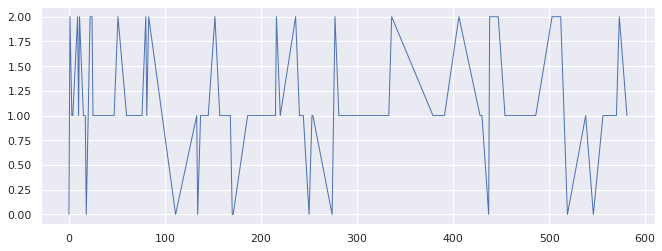

In [ ]:
manchester_city['Sentiment'].plot(linewidth=1);

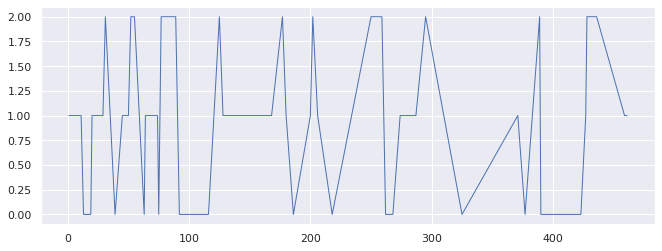

In [ ]:
spurus['Sentiment'].plot(linewidth=1);

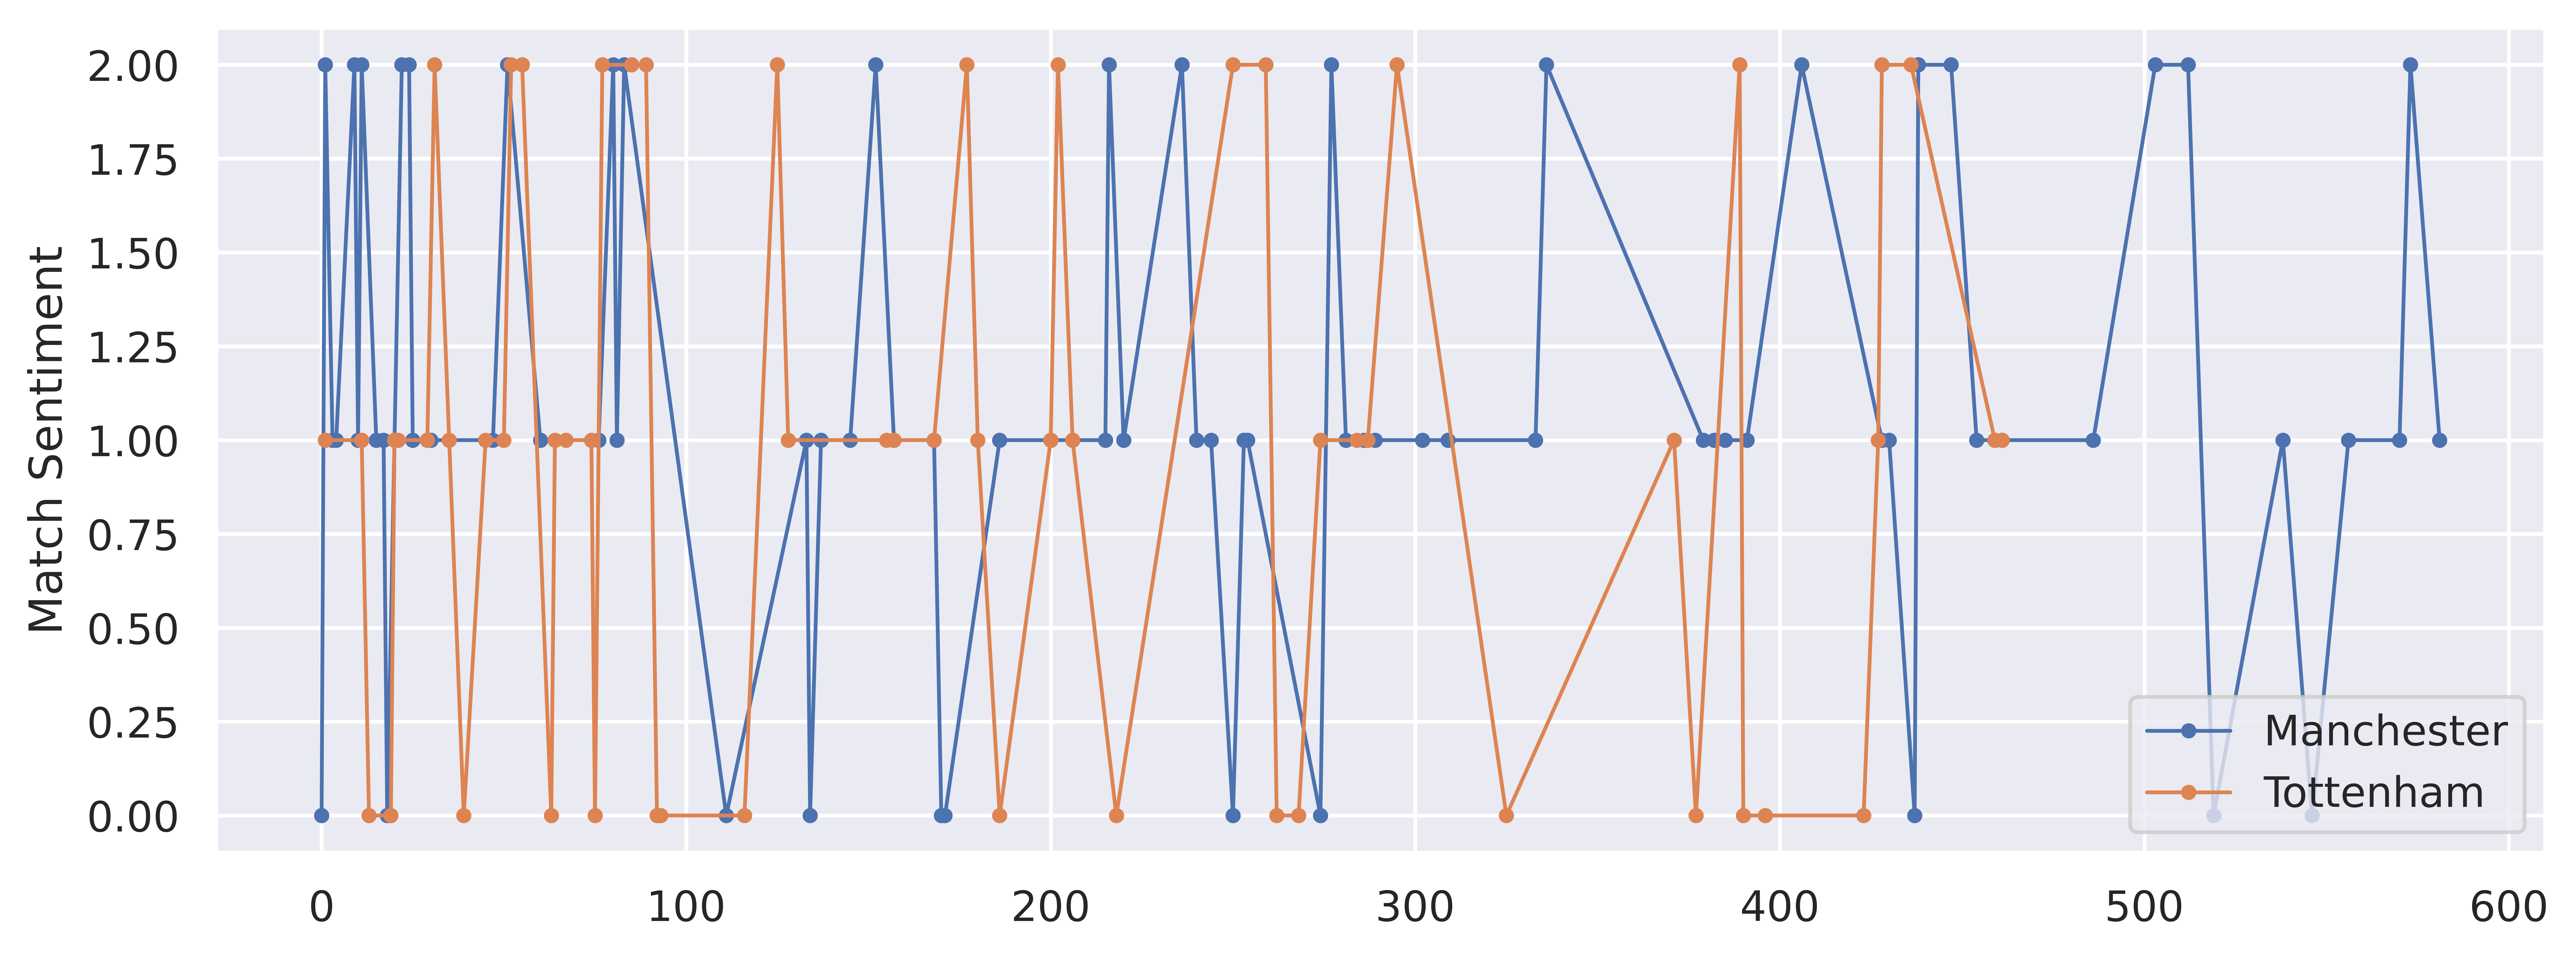

In [ ]:
fig, ax = plt.subplots()

fig.dpi = 1200
ax.plot(manchester_city['Sentiment'],
marker='.', linestyle='-', linewidth=1, label='Manchester')
ax.plot(spurus['Sentiment'],
marker='.', linestyle='-', linewidth=1, label='Tottenham')

ax.set_ylabel('Match Sentiment')
ax.legend();